In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import *
sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1]))
from src.utils import get_experiment_cell_death_times_by_specific_siliding_window,read_experiment_cell_xy_and_death_times
from src.quanta_utils import get_neighbors
from src.SegregationIdx import SegregationIdx
savefig = False

## figure 2H

In [24]:
filtered_df = pd.read_csv(os.sep.join(os.getcwd().split(os.sep)[:-1])+"/results/SPI_calculations.csv")
filtered_df = filtered_df[filtered_df['Experiment_name'].str.contains('region', case=False, na=False)]#& ~filtered_df['Origin'].str.contains('field14_two_colony'))]
filtered_subset = filtered_df[
    (filtered_df['neighbors_dist_threshold'] == 100) &
    (filtered_df['sliding_time_window_size'] == 10)
]

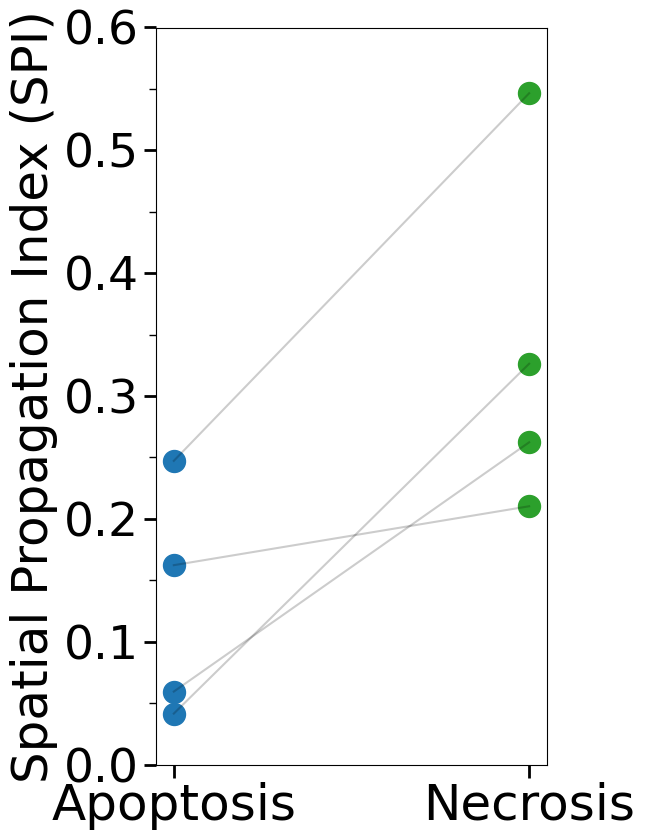

In [28]:


# Example data
custom_palette =  {"ApoptoticRegions": "#1f77b4", "NecroticRegions": "#2ca02c"}

# Replace treatment with origin and group values
# Filter the data for distance of 100 and sliding time window of 10

origins = filtered_subset['Origin'].unique()
group_a_values = []
group_b_values = []
treatment_labels = []
markers = ['o', 'o', 'o', 'o'] #markers = ['o', 'x', 's', '+']
origin_marker_dict = {origin: markers[i % len(markers)] for i, origin in enumerate(origins)}
# X positions: 0 for Group A, 1 for Group B
x_a = np.zeros(len(origins))
x_b = np.ones(len(origins))
# Assign markers based on origin
origin_markers = [origin_marker_dict[origin] for origin in origins]
for origin in origins:
    subset = filtered_subset[filtered_subset['Origin'] == origin]
    group_a = subset[subset['Treatment'] == 'ApoptoticRegions']['SPI'].mean()
    group_b = subset[subset['Treatment'] == 'NecroticRegions']['SPI'].mean()
    if not np.isnan(group_a) and not np.isnan(group_b):
        group_a_values.append(group_a)
        group_b_values.append(group_b)
        treatment_labels.append(origin)  # Use treatment labels instead of origin

# Plot
plt.figure(figsize=(6.5, 8.5))

for i in range(len(treatment_labels)):
    # Line connecting values
    plt.plot([x_a[i], x_b[i]], [group_a_values[i], group_b_values[i]], 'k-', alpha=0.2)
    # Group A point
    plt.scatter(x_a[i], group_a_values[i], color=custom_palette['ApoptoticRegions'], marker=origin_markers[i], label='ApoptoticRegions' if i == 0 else "", s=250)
    # Group B point
    plt.scatter(x_b[i], group_b_values[i], color=custom_palette['NecroticRegions'], marker=origin_markers[i], label='NecroticRegions' if i == 0 else "", s=250)

custom_legend = [Line2D([0], [0], marker=marker, color='k', markerfacecolor='k', markersize=10, label=origin)
                 for origin, marker in origin_marker_dict.items()]
# Formatting
plt.xticks([0, 1], ['Apoptosis', 'Necrosis'], fontsize=36)
plt.gca().tick_params(axis='x', which='major', length=9, width=2, labelsize=36)
plt.gca().tick_params(axis='y', which='major', length=9, width=2, labelsize=34)
plt.gca().tick_params(axis='y', which='minor', length=5, width=1)
plt.gca().set_yticks(np.arange(0.0, 0.7, 0.05), minor=True)
# plt.yticks(np.arange(0.0, 0.7, 0.05), fontsize=22)
# plt.yticks(fontsize = 22)
plt.ylabel("Spatial Propagation Index (SPI)", fontsize = 36)
# plt.title("SPI Values Across Treatments")
plt.ylim(0.0, 0.6)
plt.legend(handles=custom_legend, title="Origins", loc='lower right').remove()
plt.grid(False)
plt.tight_layout()
plt.gca().set_facecolor('none')
if savefig:
    plt.savefig(os.sep.join(os.getcwd().split(os.sep)[:-1])+"results/newSPIAcrossOrigins_paperf_dc_r.svg", format="svg", facecolor='none')
plt.show()


## figure 2G

In [41]:
exps_dir_name = os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/data/death_annotations/"
meta_data_file_full_path= os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/data/metadata.csv"
meta_data_extract_exp_names= pd.read_csv(meta_data_file_full_path)
exp_names = meta_data_extract_exp_names.iloc[:,1]
# rearrange experiment names to desired order
exp_names_u = exp_names[exp_names.str.contains(r"sample_\d+\.csv", na=False, regex=True)].reset_index(drop=True)
exp_names_u = sorted(exp_names_u)

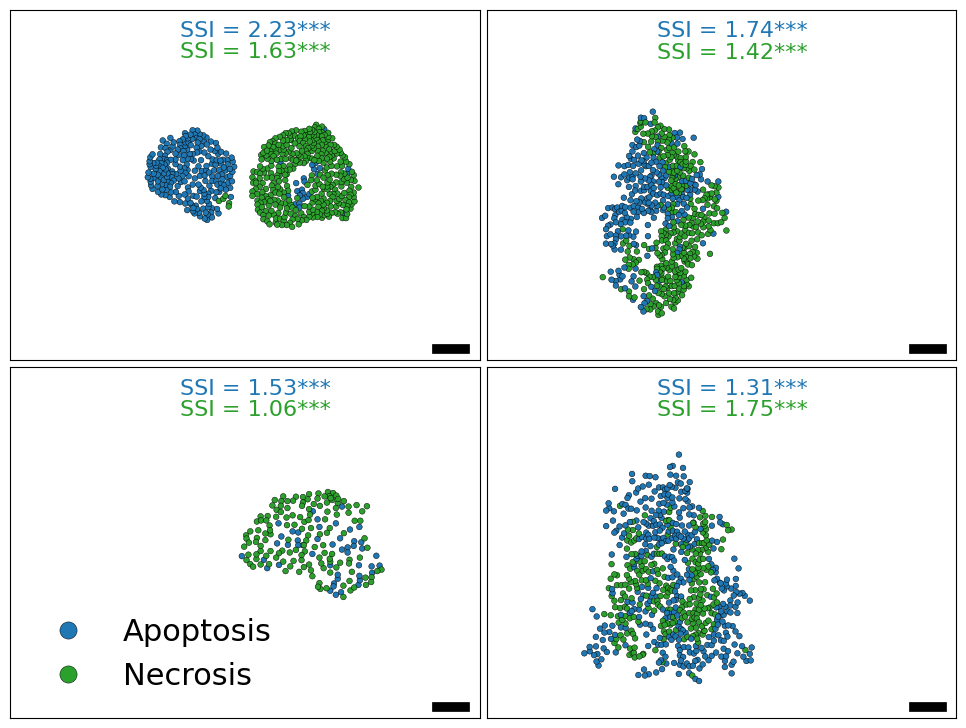

In [48]:
custom_palette = {"Apoptosis": "#1f77b4", "Necrosis": "#2ca02c", "Other": "lightgray"}
# custom_palette =  {"ApoptoticRegions": "#1f77b4", "NecroticRegions": "#2ca02c"}
# --- load SSI table ---
ssis_path = os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/results/SSI_calculations.csv"
ssis_df = pd.read_csv(ssis_path)
ssis_df = ssis_df[
    (ssis_df["neighbors_dist_threshold"] == 100)
    # & (ssis_df["sliding_time_window_size"] == 10)
]

# make sure column names match your file
ssis_df["Origin"] = ssis_df["Origin"].astype(str)
# normalize mode naming to match plotting data
ssis_df["Region"] = ssis_df["Region"].str.lower().replace(
    {"apoptotic": "apoptosis", "necrotic": "necrosis"}
)
ssis_df["Region"] = ssis_df["Region"].str.capitalize()

fig, axs = plt.subplots(2, 2, figsize=(12.3, 9.2), sharex=False, sharey=False)
axs = axs.flatten()
subplot_idx = 0

for file_name in exp_names_u:
    metadata = meta_data_extract_exp_names[meta_data_extract_exp_names["File Name"] == file_name]
    if metadata.empty:
        print(f"Metadata not found for {file_name}. Skipping...")
        continue
    size_x = int(metadata["SizeX"].values[0])
    size_y = int(metadata["SizeY"].values[0])
    physical_size_x = float(metadata["PhysicalResolution (um/px)"].values[0])
    physical_size_y = float(metadata["PhysicalResolution (um/px)"].values[0])

    x_limit = (0, size_x * physical_size_x)
    y_limit = (0, size_y * physical_size_y)

    file_path = os.path.join(exps_dir_name, file_name)
    if not os.path.exists(file_path):
        print(f"File {file_path} not found. Skipping...")
        continue

    data = pd.read_csv(file_path)
    data = data[data["Mode"].str.lower().isin(["apoptosis", "necrosis", "apoptotic", "necrotic"])]
    legend_labels = {"apoptotic": "apoptosis", "necrotic": "necrosis"}
    data["Mode"] = data["Mode"].replace(legend_labels)
    data["Mode"] = data["Mode"].str.capitalize()
    if data.empty:
        print(f"No valid data in {file_name}. Skipping...")
        continue

    # ----- SSI lookup for this subplot -----
    # if you filled file_to_origin; otherwise this is just file_name
    origin_key = file_name # file_to_origin.get(file_name, file_name)

    ssis_origin = ssis_df[ssis_df["File Name"] == origin_key]
    if ssis_origin.empty:
        print(f"No SSI rows for origin '{origin_key}' (file {file_name}).")
    ssi_by_region = (
        ssis_origin.groupby("Region")["SSI"].mean().to_dict()
        if "SSI" in ssis_origin.columns and not ssis_origin.empty
        else {}
    )

    ax = axs[subplot_idx]
    sns.scatterplot(
        ax=ax,
        data=data,
        x="cell_x",
        y="cell_y",
        hue="Mode",
        palette=custom_palette,
        edgecolor="black",
        s=17,
    )
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)

    aspect_ratio = (x_limit[1] - x_limit[0]) / (y_limit[1] - y_limit[0])
    ax.set_box_aspect(1 / aspect_ratio)

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
    ax.set_xlabel("", fontsize=24)
    ax.set_ylabel("", fontsize=24)

    scale_bar_length = 100
    scale_bar_x = x_limit[1] - scale_bar_length - 50
    scale_bar_y = y_limit[0] + 40
    ax.add_line(
        Line2D(
            [scale_bar_x, scale_bar_x + scale_bar_length],
            [scale_bar_y, scale_bar_y],
            color="black",
            linewidth=7,
        )
    )
    ax.set_facecolor('none')

    # --- add 2 SSI lines on top of the subplot, in the mode colors ---
    text_x = x_limit[0] + 600
    text_y = y_limit[1] - 40
    line_offset = 35

    for j, mode in enumerate(["Apoptosis", "Necrosis"]):
        if mode in ssi_by_region:
            ssi_val = ssi_by_region[mode]
            ax.text(
                text_x,
                text_y - j * line_offset if mode == "Apoptosis" else text_y - j * (line_offset+40),
                f"SSI = {ssi_val:.2f}***",
                color=custom_palette.get(mode, "black"),
                fontsize=16,
                ha="left",
                va="top",
            )

    if subplot_idx == 2:
        ax.legend(loc="lower left", fontsize=22, scatterpoints=5, markerscale=3, frameon=False)
    else:
        ax.get_legend().remove()

    subplot_idx += 1
    if subplot_idx >= len(axs):
        break

plt.subplots_adjust(wspace=0.0001, hspace=0.02)
if savefig:
    plt.savefig(
        os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/results/combined_plots_with_scalebar_and_ssi.svg",
        format="svg",
        facecolor='none'
    )
plt.show()


## figure Supplementry S1.A-B

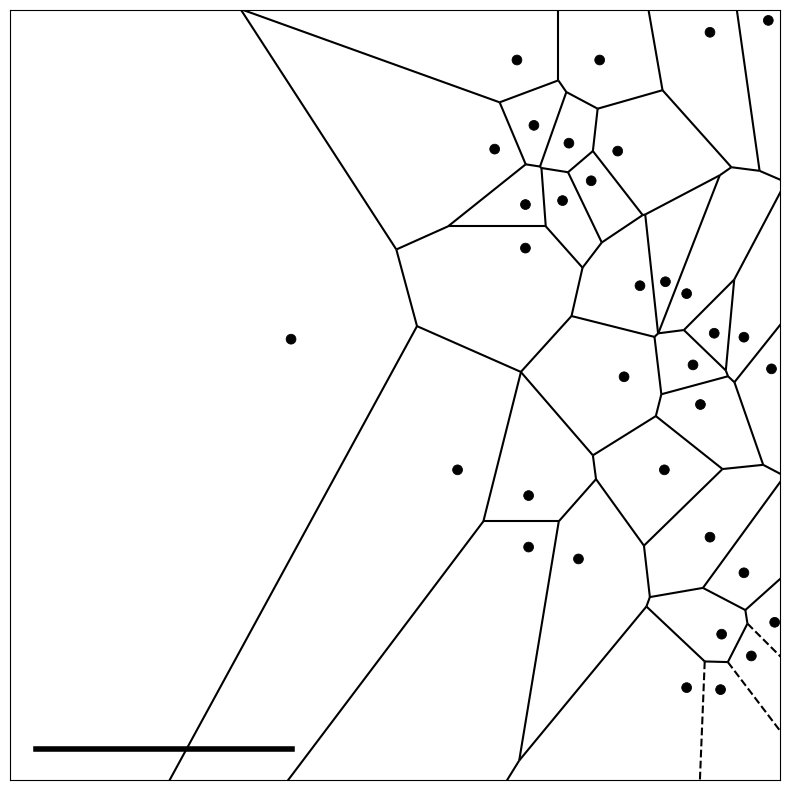

In [49]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Get the first file in the dataset
file_name = exp_names.iloc[1]

# Get metadata for the current file
metadata = meta_data_extract_exp_names[meta_data_extract_exp_names["File Name"] == file_name]
if metadata.empty:
    print(f"Metadata not found for {file_name}. Exiting...")
else:
    size_x = int(metadata["SizeX"].values[0])
    size_y = int(metadata["SizeY"].values[0])
    physical_size_x = float(metadata["PhysicalResolution (um/px)"].values[0])
    physical_size_y = float(metadata["PhysicalResolution (um/px)"].values[0])

    # Construct the full file path
    file_path = os.path.join(exps_dir_name, file_name)
    if not os.path.exists(file_path):
        print(f"File {file_path} not found. Exiting...")
    else:
        # Read the CSV file
        data = pd.read_csv(file_path)
        data = data[data["Mode"].str.lower().isin(["apoptosis", "necrosis", "apoptotic", "necrotic"])]
        legend_labels = {"apoptotic": "apoptosis", "necrotic": "necrosis"}
        data["Mode"] = data["Mode"].replace(legend_labels)
        if data.empty:
            print(f"No valid data in {file_name}. Exiting...")
        else:
            # Define the cropped area (upper-left corner)
            crop_x_limit = (300, 600)  # 25% of the x-axis
            crop_y_limit = (150, 400)  # Top 25% of the y-axis

            # Filter data for the cropped area
            cropped_data = data[
                (data["cell_x"] >= crop_x_limit[0]) & (data["cell_x"] <= crop_x_limit[1]) &
                (data["cell_y"] >= crop_y_limit[0]) & (data["cell_y"] <= crop_y_limit[1])
            ]

            # Extract points for Voronoi diagram
            points = cropped_data[["cell_x", "cell_y"]].values

            # Check if there are enough points to create a Voronoi diagram
            if len(points) < 3:
                print(f"Not enough points to create a Voronoi diagram for {file_name}. Skipping...")
            else:
                # Create Voronoi diagram
                vor = Voronoi(points)

                # Plot the Voronoi diagram
                fig, ax = plt.subplots(figsize=(8, 8))
                voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black',show_points=False, line_width=1.5)

                # Overlay the scatter plot
                sns.scatterplot(
                    ax=ax,
                    data=cropped_data,
                    x="cell_x",
                    y="cell_y",
                    hue="Mode",
                    palette={"apoptosis": "black", "necrosis": "black"},
                    edgecolor="black",
                    s=50
                )

                # Set limits to match the cropped area
                ax.set_xlim(crop_x_limit)
                ax.set_ylim(crop_y_limit)
                ax.get_legend().remove()
                # Remove x and y ticks and labels
                ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
                ax.set_xlabel("", fontsize=24)
                ax.set_ylabel("", fontsize=24)
                # Add a scale bar at the lower-right corner of the cropped area
                scale_bar_length = 100  # Length of the scale bar
                scale_bar_x = crop_x_limit[0]  + 10
                scale_bar_y = crop_y_limit[0] + 10
                ax.add_line(plt.Line2D([scale_bar_x, scale_bar_x + scale_bar_length],
                                       [scale_bar_y, scale_bar_y],
                                       color="black", linewidth=4))
                ax.set_facecolor('none')
                # Save and show the plot
                plt.tight_layout()
                plt.show()

In [60]:
import os  # Ensure os module is imported

per_5 = {}
res_si = {}
res_ob = {}
p_values = {}
expected_lik = {}
mean_shuffled = {}
shuffle_mean_full_arrays = {}
file_name = "/Users/esraan/CodeBase/CellDeathSpreading/data/death_annotations/sample_4.csv"
cells_loci, cells_times_of_death = read_experiment_cell_xy_and_death_times(exp_full_path=file_name)
csv_file = pd.read_csv(file_name)
file_name = os.path.split(file_name)[-1]
dist_threshold = 100
death_modes = csv_file[["Mode"]].values
segregation_index = SegregationIdx(cells_loci, death_modes, 1000, dist_threshold, filter_neighbors_by_distance=True, neighbors_level=1, stats_to_calculate="mean")
seg_res_dict = segregation_index.get_segregation_index(num_permutations = 1000)
distr_dict = segregation_index.permuted_si
print(seg_res_dict)
per_5[file_name] = {key: np.percentile(sorted(value),95) for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
mean_shuffled[file_name] = {key: np.mean(value) for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
shuffle_mean_full_arrays [file_name] = {key: value for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
res_si[file_name] = {key: ((value[0] / value[2]), value[1]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
res_ob[file_name] =  {key: (value[0]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
p_values[file_name] = {key: (value[1]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
expected_lik[file_name] = {key: (value[2]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}

new_res = {
    'sample_1.csv': 'field14_two_colony',
    'sample_4.csv': 'field14_colony',
    'sample_3.csv': "field11_colony",
    'sample_2.csv': 'field13_colony'
}
plot_res_dict = {new_res.get(key, key): value for key, value in res_si.items()}  # Provide default key if not found


{'apoptosis': (np.float64(0.793858132131328), np.float32(0.0), np.float64(0.6071987480438185)), 'necrosis': (np.float64(0.6813428316440363), np.float32(0.0), np.float64(0.38967136150234744)), 'entosis': (np.float64(0.19642857142857142), np.float32(0.001), np.float64(0.003129890453834116))}


In [63]:
new_res

{'sample_1.csv': 'field14_two_colony',
 'sample_4.csv': 'field14_colony',
 'sample_3.csv': 'field11_colony',
 'sample_2.csv': 'field13_colony'}

In [66]:
data = []

# Iterate over the file names in new_res
for file_name, origin in new_res.items():
    for mode in ['apoptosis', 'necrosis']:
        data.append({
            'File Name': file_name,
            'Origin': origin,
            'Mode': mode,
            'Observed': res_ob.get(file_name, {}).get(mode, None),
            'Expected': expected_lik.get(file_name, {}).get(mode, None),
            'Percentile_95': per_5.get(file_name, {}).get(mode, None),
            'Segregation Index': plot_res_dict.get(origin, {}).get(mode, (None,))[0],
            'Mean Shuffled': mean_shuffled.get(file_name, {}).get(mode, None),
            'Shuffle Mean Full Arrays': shuffle_mean_full_arrays.get(file_name, {}).get(mode, None),
            'p-value': p_values.get(file_name, {}).get(mode, None)
        })

# Create a DataFrame
df = pd.DataFrame(data)
df = df[df["File Name"].str.contains("sample_4.csv", na=False, regex=True)].reset_index(drop=True)

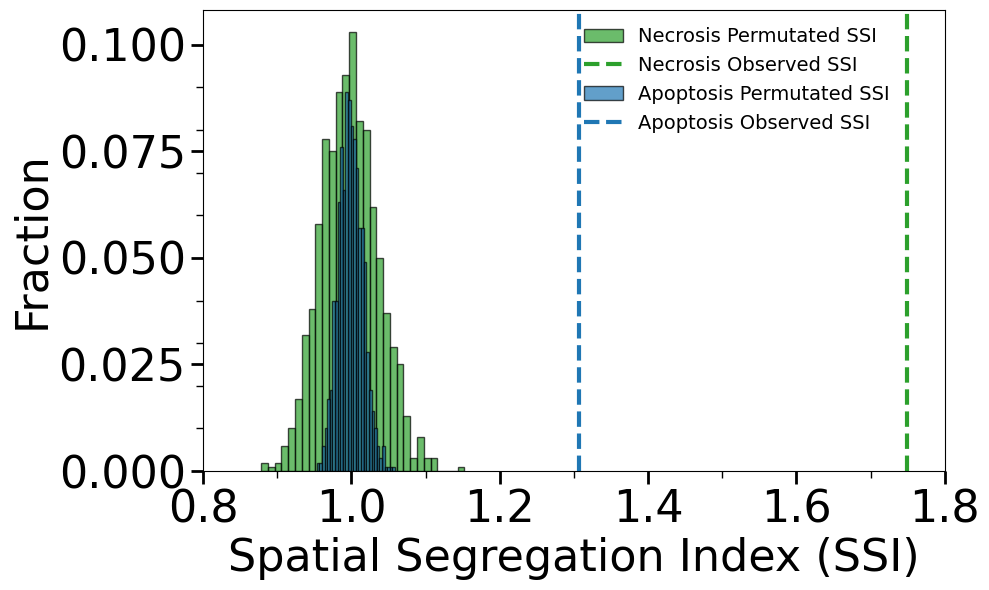

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data for a single origin
custom_palette =  {"apoptosis": "#1f77b4", "necrosis": "#2ca02c", "other": "lightgray"} #{"apoptosis": "#bf7745", "necrosis": "#f5e18a"} #

single_origin = "field14_colony"
origin_data = df[df['Origin'] == single_origin]

# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over both necrosis and apoptosis
for mode in ['necrosis', 'apoptosis']:
    mode_data = origin_data[origin_data['Mode'] == mode]
    full_array = mode_data.iloc[0]['Shuffle Mean Full Arrays']
    observed_value = mode_data.iloc[0]['Observed']

    # Plot the histogram of the full array as a fraction of 1000
    ax.hist(
        full_array / mode_data.iloc[0]['Expected'],
        bins=30,
        alpha=0.7,
        color=custom_palette[f"{mode}"],
        edgecolor='black',
        label=f"{mode.capitalize()} Permutated SSI",
        weights=np.ones_like(full_array) / 1000  # Normalize to fraction of 1000
    )

    # Add a red line for the observed value
    ax.axvline(
        observed_value / mode_data.iloc[0]['Expected'],
        color=custom_palette[f"{mode}"],
        linestyle='--',
        linewidth=3,
        label=f"{mode.capitalize()} Observed SSI"
    )
    ax.set_facecolor('none')

# Add labels, title, and legend
ax.legend(frameon=False, fontsize=14, loc='upper center', bbox_to_anchor=(0.72, 1.0))

plt.gca().tick_params(axis='x', which='major', length=9, width=2, labelsize=32)
plt.gca().tick_params(axis='x', which='minor', length=5, width=1)
plt.gca().tick_params(axis='y', which='major', length=9, width=2, labelsize=32)
plt.gca().tick_params(axis='y', which='minor', length=5, width=1)
plt.gca().set_yticks(np.arange(0, 0.10, 0.01), minor=True)  # Adjusted for fractions
plt.gca().set_xticks(np.arange(0.8, 1.85, 0.1), minor=True)

plt.xlabel("Spatial Segregation Index (SSI)", fontsize=32)
plt.ylabel("Fraction", fontsize=32)  # Updated label
plt.grid(False)
plt.tight_layout()
plt.gca().set_facecolor('none')
# plt.savefig("/home/esraan/CellDeathSpreading/results/ssi_fraction_nos_big.svg", format="svg", facecolor='none')
plt.show()